Code below was obtained from [here](https://pdfminersix.readthedocs.io/en/latest/tutorial/composable.html)

In [33]:
# This block and the block below it were promising, but the documentation for pdfminer is practically
# non-existent, so I don't really want to use it if I don't know what it's doing. Plus, each solution didn't
# work well on 2 column papers

from io import StringIO

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

def convert_pdf_to_string(file_path):
    output_string = StringIO()
    with open(file_path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)

    return(output_string.getvalue())


Code below obtained from [here](https://stackoverflow.com/questions/26494211/extracting-text-from-a-pdf-file-using-pdfminer-in-python)

In [12]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convert_pdf_to_text(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

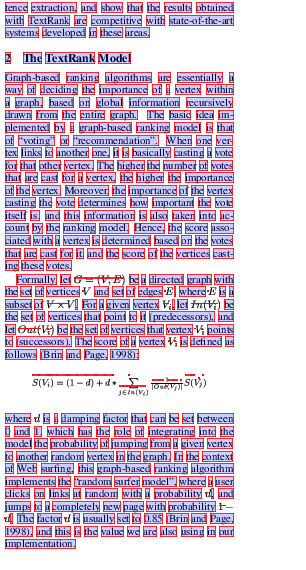

In [1]:
# This seems to be the winner!
# This code is just to extract the text from the first page of a 2 column paper.
# I'll need to make some adjustments to the crop boundaries for the other pages (since only the
# first page has the title header information)
# I'll also need to write a version of this for single column papers, but that should be easier

import pdfplumber



# read the pdf
with pdfplumber.open("test papers/textrank algorithm paper.pdf") as pdf:
    # get the first page
    page = pdf.pages[0]
    
    # crop the left and right columns, excluding the top header (which is exclusive to the first page)
    left = page.crop((0, 0.21 *  page.height, 0.5 * float(page.width), 0.9 * float(page.height)))
    right = page.crop((0.5 * page.width, 0.21 * page.height, page.width, 0.93 * page.height))
    
    # this converts the right colummn of the page to an image, used for debugging purposes
    img = right.to_image()
    
    # also for debugging. It shows the boxes for each word on the page
    img.draw_rects(page.extract_words(x_tolerance=2))
    
    # extract the text from the left and right columns
    l_text = left.extract_text(x_tolerance=1.5)
    r_text = right.extract_text(x_tolerance=1.5)
    
    # merge them together
    text = l_text + " " + r_text

# display right column img for debugging
img

pdfplumber documentation [here](https://github.com/jsvine/pdfplumber)

In [2]:
# library for regular expressions
import re

# removes newline characters
text = re.sub("\n", " ", text)

# removes the occurence of "(cid:[number])". This seems to be how pdfplumber spits out LaTeX, so I removed it
# as it's just noise
text = re.sub("\(cid:\d*\)", "", text)

# merges together words that get split due to line breaks (e.g sen- tence)
text = re.sub("([a-z])-\s", r'\1', text)

# print the text
print(text)

Abstract In this paper, we introduce TextRank – a graph-based ranking model for text processing, and show how this model can be successfully used in natural language applications. In particular, we propose two innovative unsupervised methods for keyword and sentence extraction, and show that the results obtained compare favorably with previously published results on established benchmarks. 1 Introduction Graph-based ranking algorithms like Kleinberg’s HITS algorithm (Kleinberg, 1999) or Google’s PageRank (Brin and Page, 1998) have been successfully used in citation analysis, social networks, and the analysis of the link-structure of the World Wide Web. Arguably, these algorithms can be singled out as key elements of the paradigm-shift triggered in the ﬁeld of Web search technology, by providing a Web page ranking mechanism that relies on the collective knowledge of Web architects rather than individual content analysis of Web pages. In short, a graph-based ranking algorithm is a way of

In [30]:
# Now, to extract the rest of the text from 2 col papers
# What to do about footnotes? Can probably just leave them, but they may be confusing if they interrupt a sentence

# read the pdf
with pdfplumber.open("test papers/textrank algorithm paper.pdf") as pdf:
    text = ""
    for i in range(1, len(pdf.pages), 1):
        page = pdf.pages[i]

        # crop the left and right columns
        left = page.crop((0, 0, 0.5 * float(page.width), 0.9 * float(page.height)))
        right = page.crop((0.5 * page.width, 0.21 * page.height, page.width, page.height))

#         # this converts the right colummn of the page to an image, used for debugging purposes
#         img = left.to_image()

#         # also for debugging. It shows the boxes for each word on the page
#         img.draw_rects(page.extract_words(x_tolerance=2))

        # extract the text from the left and right columns
        l_text = left.extract_text(x_tolerance=0.5)
        r_text = right.extract_text(x_tolerance=0.5)

        # merge them together
        text += " " + l_text + " " + r_text
        

# display right column img for debugging
print(text)

 Starting from arbitrary values assigned to each
node in the graph, the computation iterates until con-
vergence below a given threshold is achieved 1 . After
running the algorithm, a score is associated with each
vertex, which represents the “importance” of the ver-
tex within the graph. Notice that the ﬁnal values
obtained after TextRank runs to completion are not
affected by the choice of the initial value, only the
number of iterations to convergence may be differ-
ent.
It is important to notice that although the TextRank
applications described in this paper rely on an al-
gorithm derived from Google’s PageRank (Brin and
Page, 1998), other graph-based ranking algorithms
such as e.g. HITS (Kleinberg, 1999) or Positional
Function (Herings et al., 2001) can be easily inte-
grated into the TextRank model (Mihalcea, 2004).
2.1 Undirected Graphs
Although traditionally applied on directed graphs, a
recursive graph-based ranking algorithm can be also
applied to undirected graphs, in which 

In [16]:
with pdfplumber.open("test papers/textrank algorithm paper.pdf") as pdf:
    print(len(pdf.pages))

8


In [31]:
# library for regular expressions
import re

# removes newline characters
#text = re.sub("\n", " ", text)

# removes the occurence of "(cid:[number])". This seems to be how pdfplumber spits out LaTeX, so I removed it
# as it's just noise
text = re.sub("\(cid:\d*\)", "", text)

# merges together words that get split due to line breaks (e.g sen- tence)
text = re.sub("([a-z])-\s", r'\1', text)

# print the text
print(text)

 Starting from arbitrary values assigned to each
node in the graph, the computation iterates until convergence below a given threshold is achieved 1 . After
running the algorithm, a score is associated with each
vertex, which represents the “importance” of the vertex within the graph. Notice that the ﬁnal values
obtained after TextRank runs to completion are not
affected by the choice of the initial value, only the
number of iterations to convergence may be different.
It is important to notice that although the TextRank
applications described in this paper rely on an algorithm derived from Google’s PageRank (Brin and
Page, 1998), other graph-based ranking algorithms
such as e.g. HITS (Kleinberg, 1999) or Positional
Function (Herings et al., 2001) can be easily integrated into the TextRank model (Mihalcea, 2004).
2.1 Undirected Graphs
Although traditionally applied on directed graphs, a
recursive graph-based ranking algorithm can be also
applied to undirected graphs, in which case the o

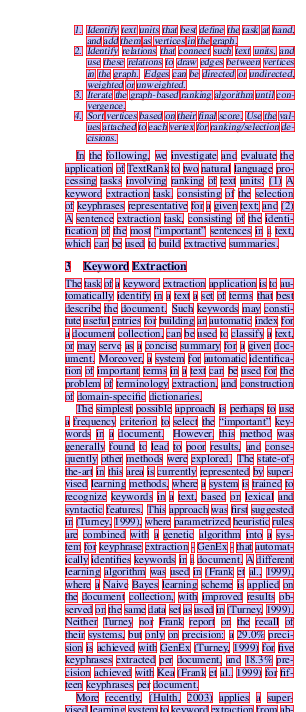

In [29]:
# debugging 3rd page of textrank paper. italics font got all smushed together

with pdfplumber.open("test papers/textrank algorithm paper.pdf") as pdf:
    # get the first page
    page = pdf.pages[2]
    
    # crop the left and right columns, excluding the top header (which is exclusive to the first page)
    left = page.crop((0, 0, 0.5 * float(page.width), 0.9 * float(page.height)))
    right = page.crop((0.5 * page.width, 0.21 * page.height, page.width, page.height))
    
    # this converts the right colummn of the page to an image, used for debugging purposes
    img = left.to_image()
    
    # also for debugging. It shows the boxes for each word on the page
    img.draw_rects(page.extract_words(x_tolerance=0.5))
    
    # extract the text from the left and right columns
    l_text = left.extract_text(x_tolerance=0.5)
    r_text = right.extract_text(x_tolerance=1.5)
    
    # merge them together
    text = l_text + " " + r_text

# display right column img for debugging
img